# Data Text

## library

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from tf_keras.src.callbacks import EarlyStopping

## Load Dataset

In [2]:
url = "https://drive.google.com/uc?id=17Jws3tYtnfB70sr5aKcQj0815xV_R8o5"
df = pd.read_csv(url)
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


## Eksplorasi Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


In [4]:
df.describe()

,cleaned_review_length,review_score
count,17340.000000,17340.000000
mean,30.300461,3.649077
std,35.836540,1.673500
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


In [5]:
print("Distribusi Sentiments:")
df['sentiments'].value_counts()

Distribusi Sentiments:


,count
sentiments,
positive,9503
neutral,6303
negative,1534


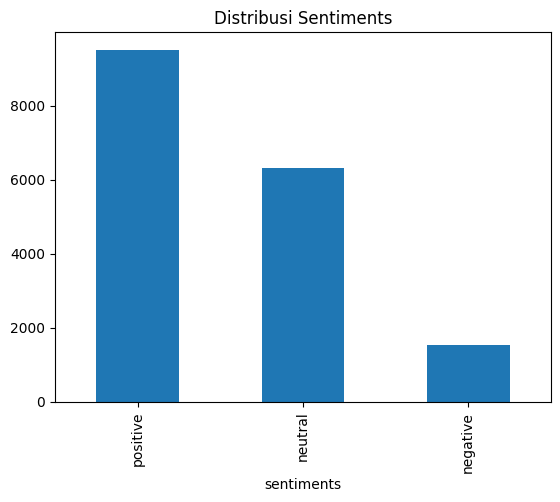

In [6]:
df['sentiments'].value_counts().plot(kind='bar', title='Distribusi Sentiments')
plt.show()

In [7]:
df.isnull().sum()

,0
sentiments,0
cleaned_review,3
cleaned_review_length,0
review_score,0


In [8]:
df.fillna('', inplace=True)

In [9]:
df.isnull().sum()

,0
sentiments,0
cleaned_review,0
cleaned_review_length,0
review_score,0


## Preprocessing

In [10]:
def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    return ' '.join(new_words)

## Augmentation

In [11]:
positive_df = df[df['sentiments'] == 'positive']
neutral_df = df[df['sentiments'] == 'neutral']
negative_df = df[df['sentiments'] == 'negative']

In [12]:
target_count = len(positive_df)

In [13]:
neutral_augmented = []
while len(neutral_augmented) + len(neutral_df) < target_count:
    for text in neutral_df['cleaned_review']:
        if text.strip():
            augmented_text = random_deletion(text, p=0.2)
            neutral_augmented.append(augmented_text)

negative_augmented = []
while len(negative_augmented) + len(negative_df) < target_count:
    for text in negative_df['cleaned_review']:
        if text.strip():
            augmented_text = random_deletion(text, p=0.2)
            negative_augmented.append(augmented_text)

In [14]:
# DataFrame untuk data augmented
neutral_augmented_df = pd.DataFrame({'cleaned_review': neutral_augmented, 'sentiments': 'neutral'})
negative_augmented_df = pd.DataFrame({'cleaned_review': negative_augmented, 'sentiments': 'negative'})

# Gabungkan data asli dan augmented
balanced_df = pd.concat([positive_df, neutral_df, neutral_augmented_df, negative_df, negative_augmented_df])

In [15]:
print("\nDistribusi Kelas Setelah Augmentasi:")
balanced_df['sentiments'].value_counts()


Distribusi Kelas Setelah Augmentasi:


,count
sentiments,
neutral,12587
negative,10738
positive,9503


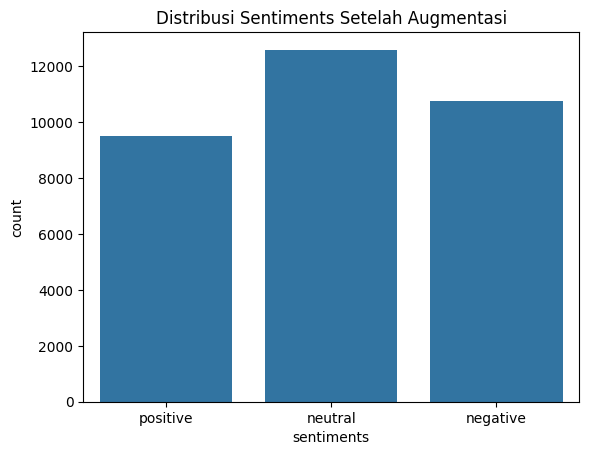

In [16]:
sns.countplot(x=balanced_df['sentiments'])
plt.title('Distribusi Sentiments Setelah Augmentasi')
plt.show()

## Transfer Learning BERT

In [17]:
X = df['cleaned_review']
y = df['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="tf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Compile model
optimizer = AdamWeightDecay(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/10
694/694 [==============================] - 353s 477ms/step - loss: 0.4157 - accuracy: 0.8239 - val_loss: 0.2757 - val_accuracy: 0.8923
Epoch 2/10
694/694 [==============================] - 330s 475ms/step - loss: 0.2161 - accuracy: 0.9154 - val_loss: 0.2357 - val_accuracy: 0.9117
Epoch 3/10
694/694 [==============================] - 326s 470ms/step - loss: 0.1258 - accuracy: 0.9542 - val_loss: 0.2620 - val_accuracy: 0.9038
Epoch 4/10
694/694 [==============================] - 326s 470ms/step - loss: 0.0803 - accuracy: 0.9726 - val_loss: 0.2482 - val_accuracy: 0.9171
Epoch 5/10
694/694 [==============================] - 326s 470ms/step - loss: 0.0751 - accuracy: 0.9737 - val_loss: 0.2673 - val_accuracy: 0.9214


## Evaluasi Model

In [22]:
y_pred = np.argmax(model.predict(test_encodings.data).logits, axis=1)
y_test_encoded = label_encoder.transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=['negative', 'neutral', 'positive']))

109/109 [==============================] - 33s 278ms/step

Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.70      0.77       307
     neutral       0.86      0.89      0.88      1261
    positive       0.95      0.95      0.95      1900

    accuracy                           0.91      3468
   macro avg       0.89      0.85      0.87      3468
weighted avg       0.91      0.91      0.91      3468



In [23]:
loss, accuracy = model.evaluate(test_encodings.data, y_test_encoded) # Changed y_test to y_test_encoded
print(f"Accuracy: {accuracy}")

109/109 [==============================] - 33s 278ms/step - loss: 0.2344 - accuracy: 0.9097
Accuracy: 0.9097462296485901


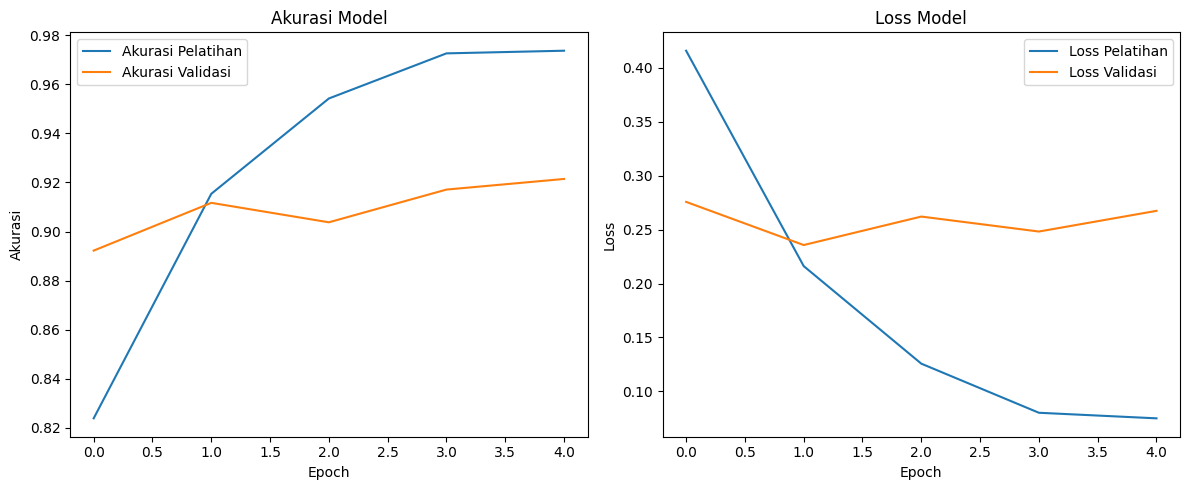

In [28]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

# Plot akurasi pelatihan
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend()

# Plot loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Prediksi Data Uji

In [25]:
predicted_labels = label_encoder.inverse_transform(y_pred)

In [26]:
# Membandingkan hasil prediksi
comparison = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})
print(comparison.head())

      True Label  Predicted Label
11915   negative                1
3630    positive                2
3264    positive                2
14247    neutral                1
4856    negative                0


In [27]:
# Analisis perbedaan
comparison['Correct'] = comparison['True Label'] == comparison['Predicted Label']
print(comparison['Correct'].value_counts())

Correct
False    3468
Name: count, dtype: int64


# Save Model

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/Study/Machine Learning/Modul 5/BERTModel'

# Buat direktori jika belum ada
os.makedirs(model_save_path, exist_ok=True)

# Simpan model dan tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)